In [144]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
import matplotlib.pyplot as plt
import template_funciones as func


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [145]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

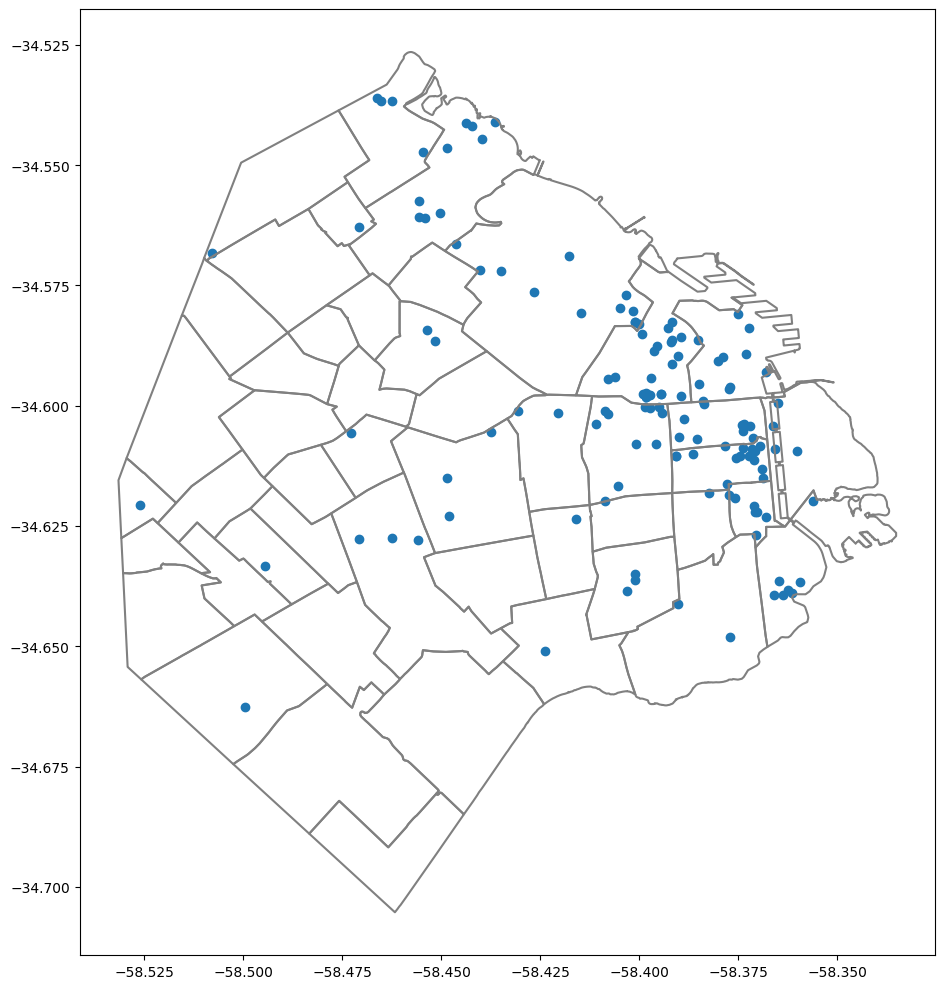

In [146]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [147]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [148]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)


## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [149]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

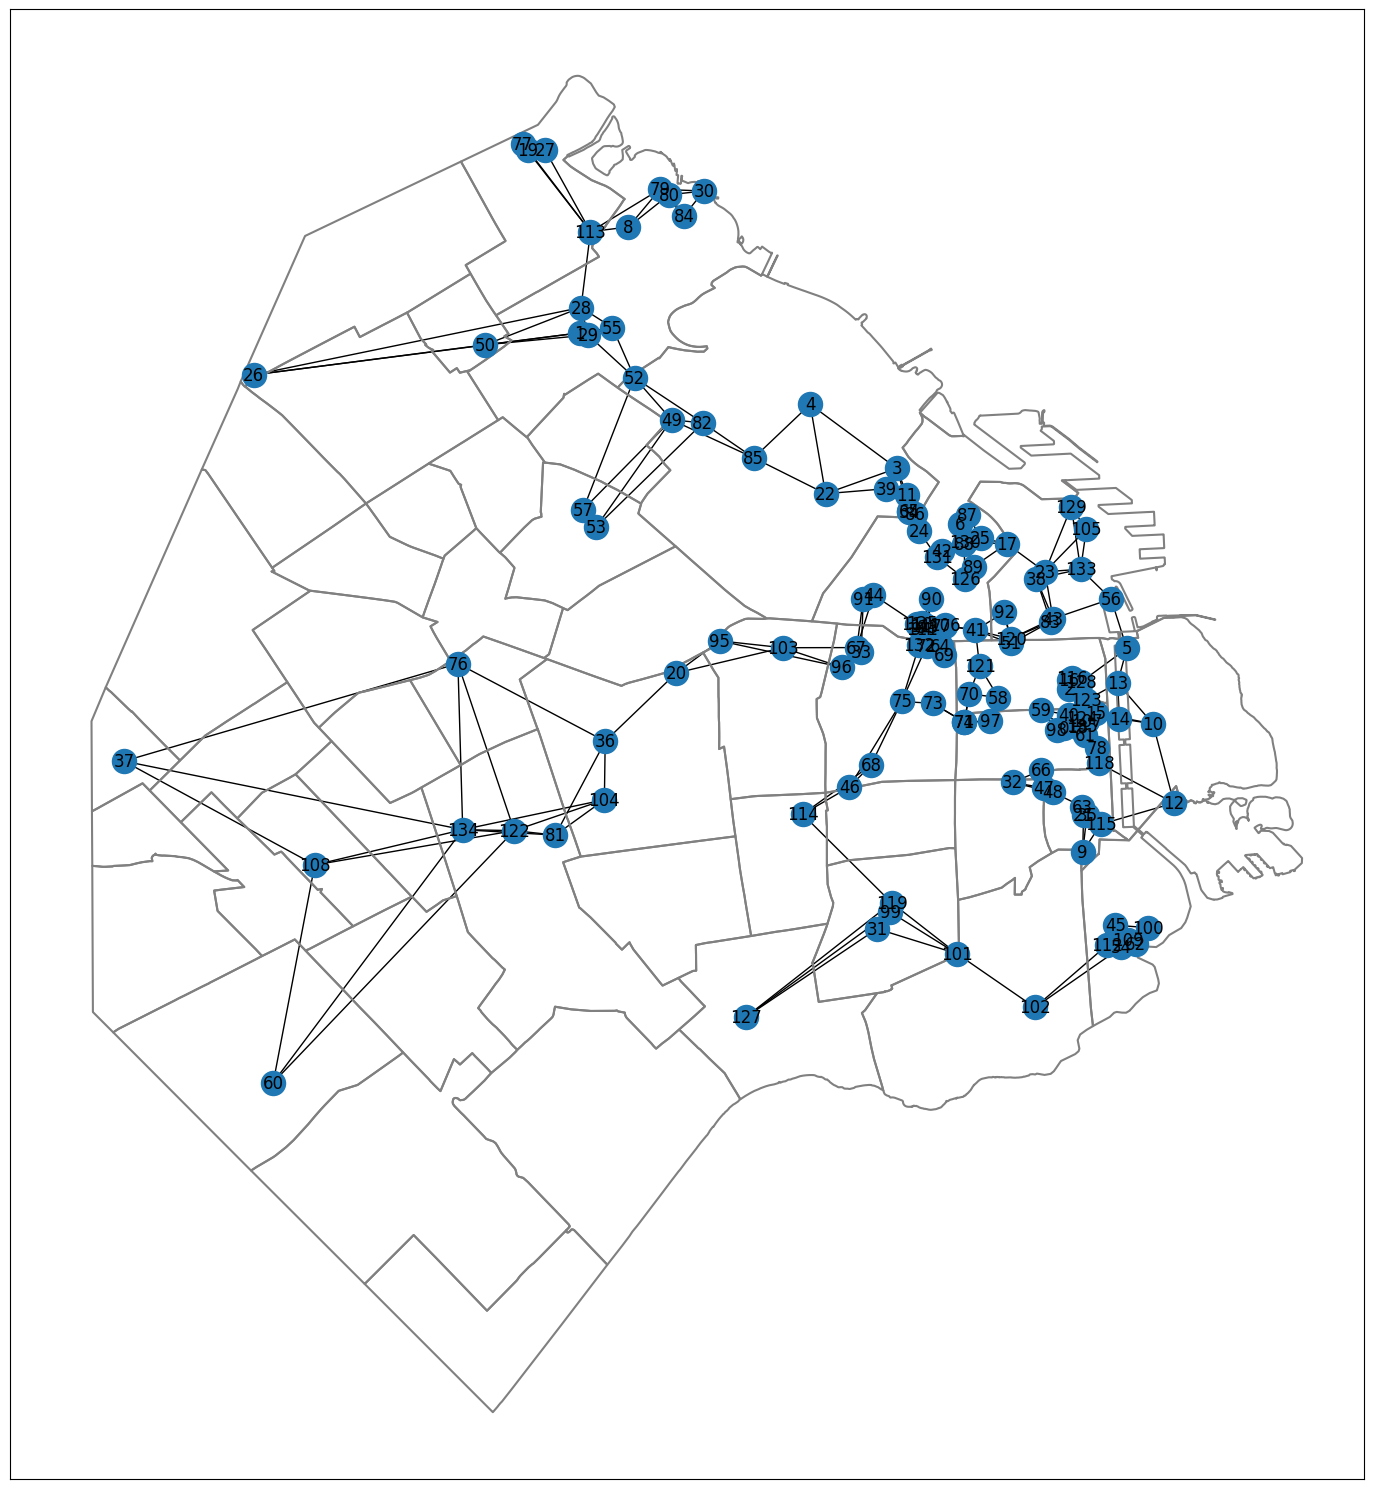

In [150]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1: TERMINADO
Debemos demostrar que el vector de rankings ***p*** es solución de la ecuación $M$ ***p*** = ***b*** donde

$$M = \frac{\it{N}}{α} (I - (1 - α) C ) \land  b = 1 $$

El objetivo entonces va a ser llegar a esta igualdad algebraicamente comenzando por la ecuación original de ***p***.

$$p = (1 - α) C p + \frac{α}{\it{N}} \space1$$

Comenzamos despejando ***1***

$$p - (1 - α) C p = \frac{α}{\it{N}}\space 1 $$

$$\frac{\it{N}}{α} p - \frac{\it{N}}{α}(1 - α) C p = 1$$

Sacamos factor común ***p***, en el proceso hacemos "aparecer" la matriz identidad en el primér término.

$$p (\frac{\it{N}}{α} I - \frac{\it{N}}{α}(1 - α) C ) = 1$$

$$p \frac{\it{N}}{α} (I - (1 - α) C ) = 1$$

Finalmente llegamos a la ecuación original, ***p*** $M$ = ***1***

Queda demostrado que el vector ***p*** es solución de la ecuación


## Punto 2: TERMINADO

Debemos encontrar las condiciones para que exista una única solución a la ecuación $M p = b$

Esto ocurre únicamente si la matriz $M$ es inversible.

$$M^{-1} = (\frac{\it{N}}{α} (I - (1 - α) C ))^{-1}$$

$$M^{-1} \neq 0 ⇒ (\frac{\it{N}}{α} (I - (1 - α) C ))^{-1} \neq 0$$

 Desarrollo algebraicamente la parte derecha de la implicación


$$\frac{α}{\it{N}} (I - (1 - α) C )^{-1} \neq 0 $$

$$ \frac{α}{\it{N}}  \neq 0 \space \land \space (I - (1 - α) C )^{-1} \neq 0 $$

Por un lado vemos que $\frac{α}{\it{N}} \neq 0 \space \forall α \in (0, 1)$ pues $α = 0$ no está incluido en el conjunto.

Nos queda ver si $I - (1 - α) C$, a la cual paso a llamar $g$, es inversible. Me fijo si es estríctamente diagonal dominante. Nos vamos a fijar si lo es por columnas. Queremos probar que:

$$ |g_{jj}| > \sum_{\substack{i = 1 \\ i \ne j}}^{n} |g_{ij}| $$

Veamos cuanto es la parte mayor de la desigualdad

$$ g_{jj} = I_{jj} - (1 - α) C_{jj} $$

Por definición de $C$ tiene ceros en sus diagonales, por lo que:

$$ g_{jj} = 1 - (1 - α) * 0 = 1 $$

Estudiemos la otra parte de la desigualdad.

$$ \sum_{\substack{i = 1 \\ i \ne j}}^{n} |g_{ij}| = \sum_{\substack{i = 1 \\ i \ne j}}^{n} | I_{ij} - (\alpha - 1) C_{ij}| $$

Por un lado la sumatoria de las columnas de la identidad sin el elemento de la diagonal es 0. Por otro sabemos que la matriz $C$ es estocástica por definición. Es decir, sus columnas suman 1. Como el único elemento que no estamos sumando es el 0 de la diagonal, el elemento $C_{ij}$ adentro de la sumatoria da 1. Por lo que queda:

$$ \sum_{\substack{i = 1 \\ i \ne j}}^{n} |g_{ij}| =  |1 - \alpha|$$

$$ 0 < \alpha < 1 \ ⇒ 0 < |1 - \alpha| < 1 \space \forall α \in (0, 1) $$

Finalmente probamos la desigualdad $|g_{jj}| > \sum_{\substack{i = 1 \\ i \ne j}}^{n} |g_{ij}|$. Queda demostrado que la matriz $M$ cumple las condiciones para que exista una única solución a la ecuación dada en el punto 1 pues tiene inversa para todo $0 < \alpha < 1$.

## Punto 3:

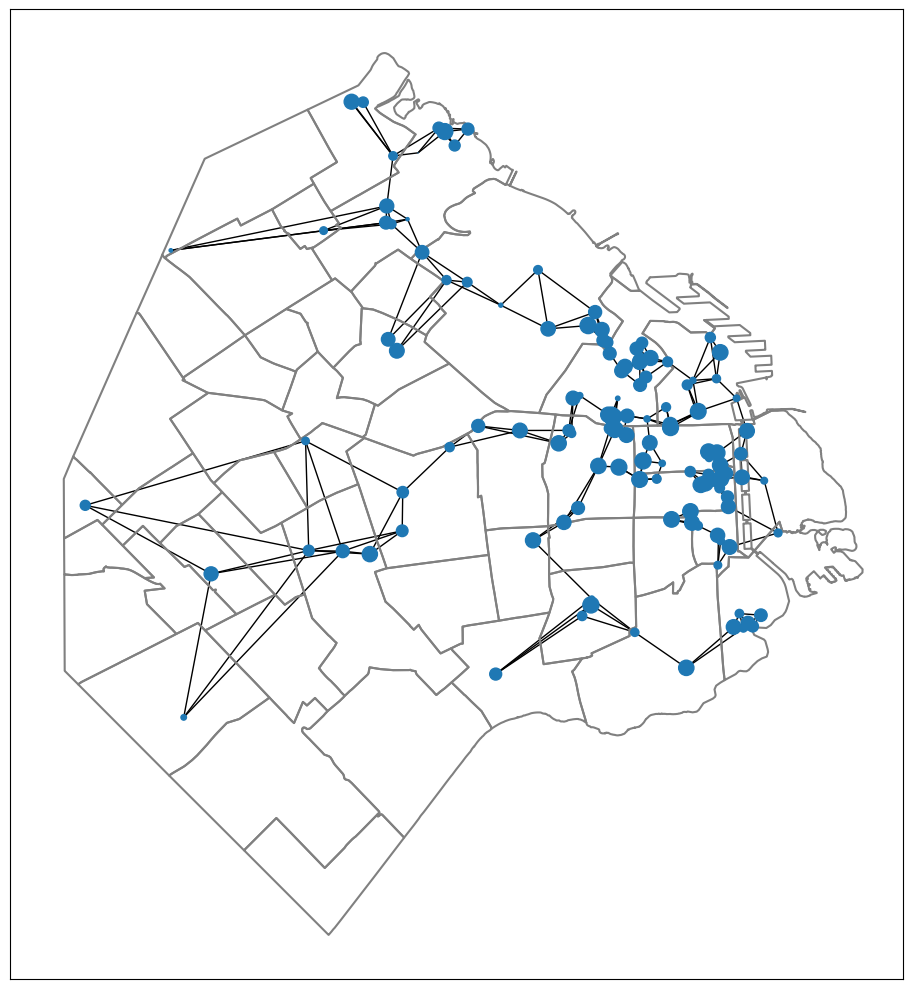

In [247]:
def graficar_pagerank(pr,museos,barrios,size):
    G = nx.from_numpy_array(C) # Construimos la red a partir de la matriz de adyacencia
    # Construimos un layout a partir de las coordenadas geográficas
    G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
    fig, ax = plt.subplots(figsize=(size, size)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
    pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
    pr = pr/pr.sum() # Normalizamos para que sume 1
    nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red

D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()
m = 3
A = construye_adyacencia(D,m)
alfa = 1/5
#pr = func.calcula_pagerank(C,alfa)
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
graficar_pagerank(pr,museos,barrios,10)


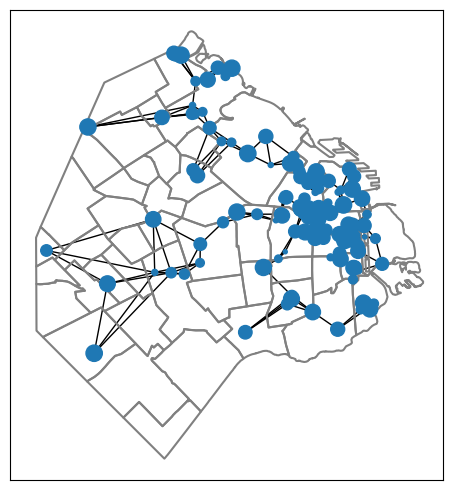

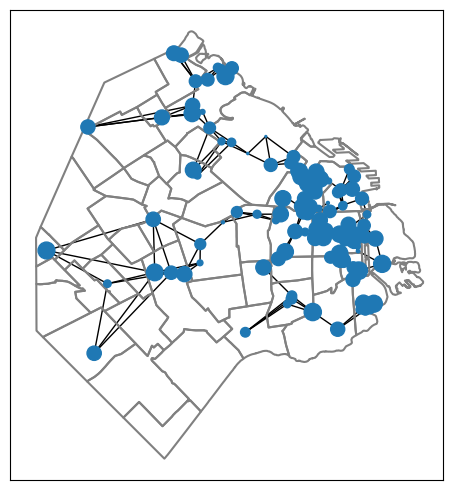

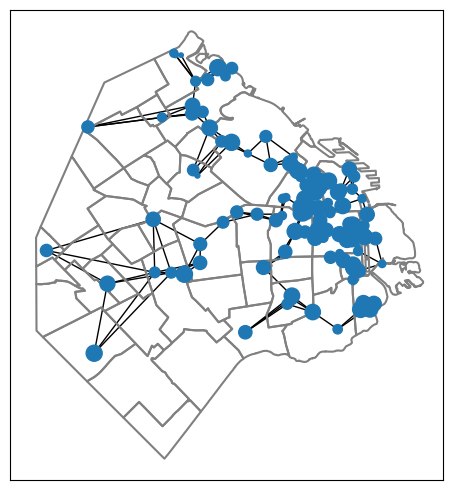

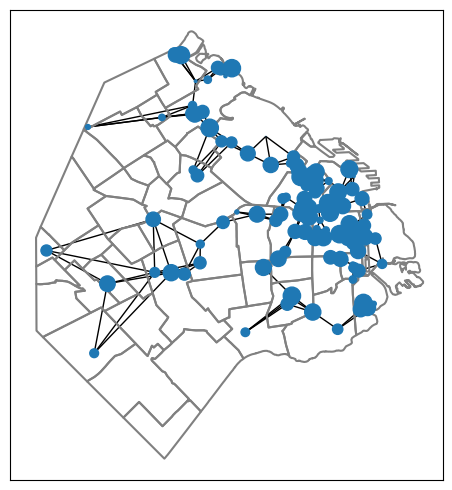

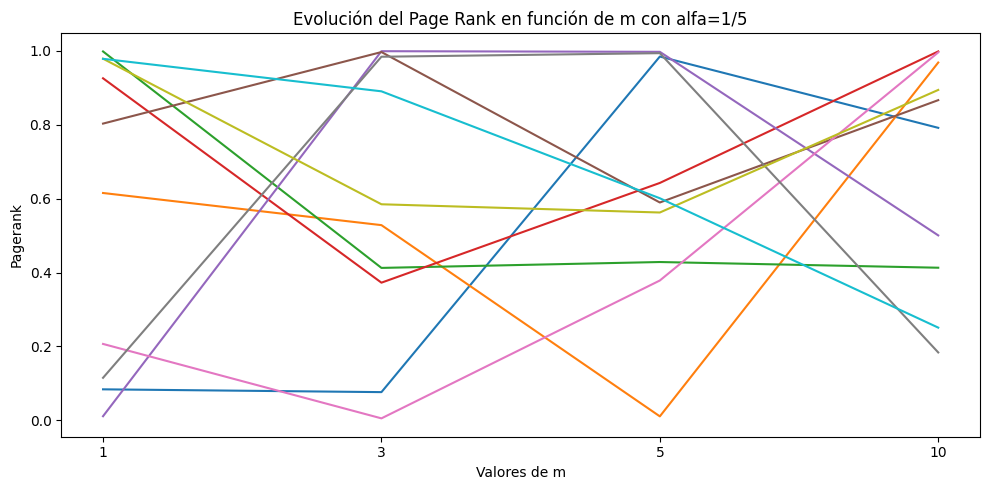

In [250]:

m_list = [1,3,5,10]

Nprincipales = 3 # Cantidad de principales
pr_list = [] # Lista para guardar scores 

alfa = 1/5 # Valor de alfa para el Page Rank
for m in m_list:
    A = construye_adyacencia(D,m)
    pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
    pr_list.append(pr) 
    graficar_pagerank(pr,museos,barrios,5)
plt.show() # purga configuracion


# guardamos los 3 principales nodos de cada una de las listas
principales = {}
for i, pr in enumerate(pr_list):
    principales[i] = np.argsort(pr)[-Nprincipales:]
# deduplicamos los nodos principales, para quedarnos con los únicos
principales = set([n for i in principales.values() for n in i]) 
# cada elemento de pr_principiantes es una lista con los pagerank del nodo correspondiente
pr_principales = []
for i, principal in enumerate(principales):
    pr_singular = [] 
    for j, pr in enumerate(pr_list):
        pr_singular.append(pr[principal]) 
    pr_principales.append(pr_singular) 

# print(principales)
# print(pr_principales)
# print(len(principales))
# print(np.shape(pr_principales)[0])
# print(np.shape(pr_principales)[1])

x = np.arange(len(m_list)) # Valores de m

plt.xlabel('Valores de m')
plt.ylabel('Pagerank')
plt.title('Evolución del Page Rank en función de m con alfa=1/5')

plt.xticks(x, m_list)

for pr in pr_principales:
    y = np.array(pr_principales[0]) 
    plt.plot(x, pr) # Graficamos los scores de Page Rank de cada nodo principal

plt.show()


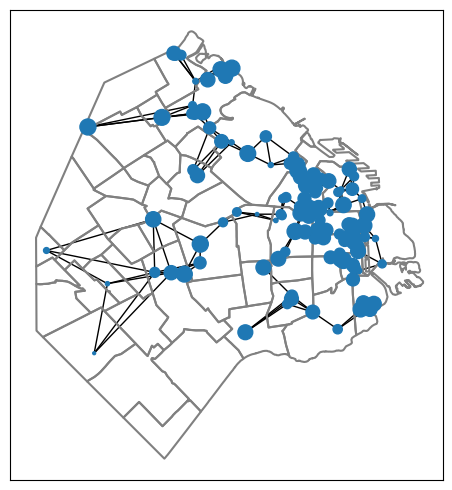

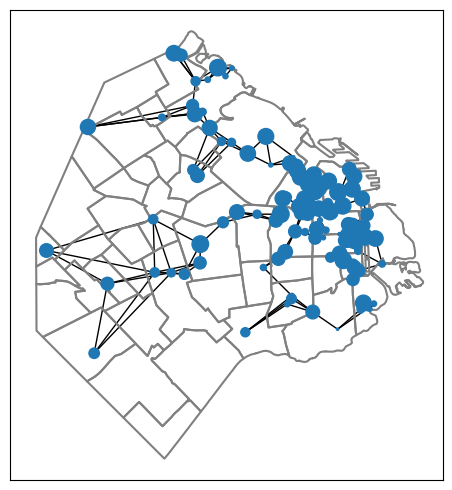

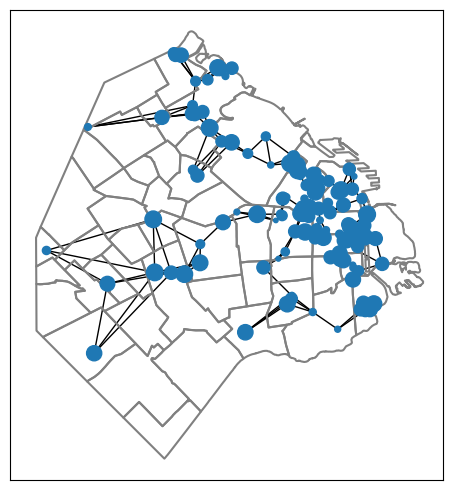

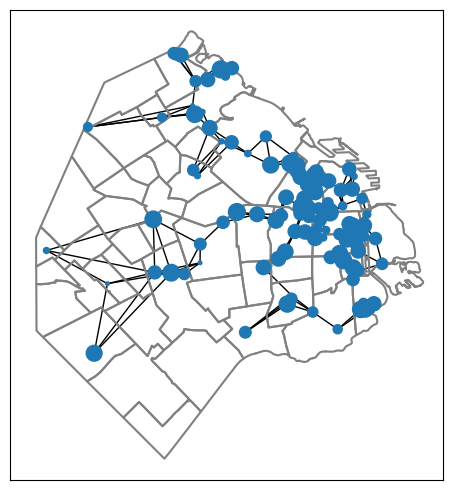

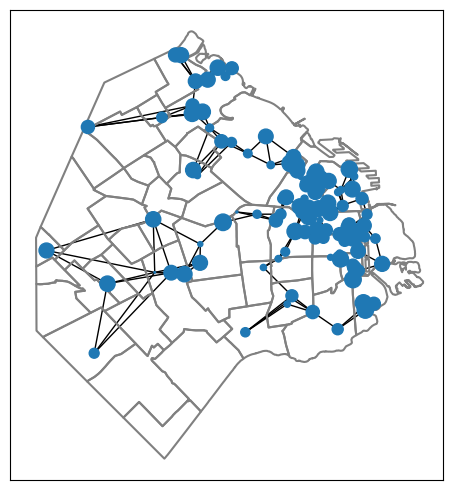

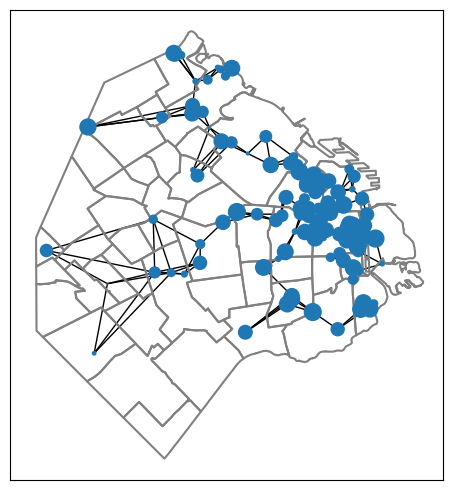

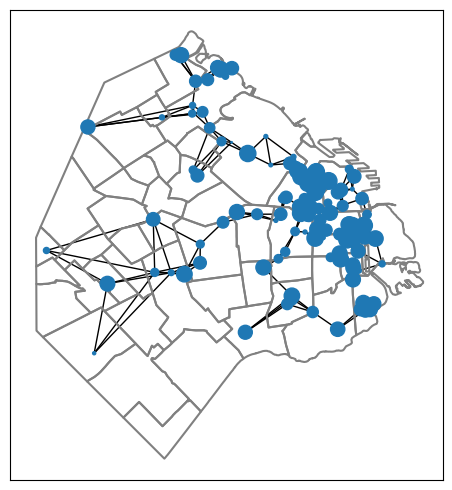

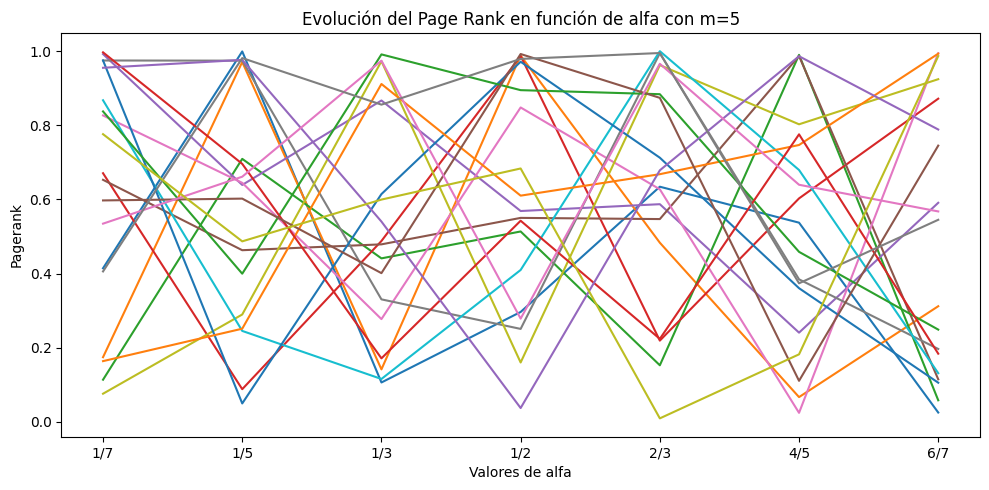

In [ ]:

alfa_list = [1/7,1/5,1/3,1/2,2/3,4/5,6/7]
pr_list = [] 

m = 5
for alfa in alfa_list:
    A = construye_adyacencia(D,m)
    pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
    pr_list.append(pr) # Guardamos el scor
    graficar_pagerank(pr,museos,barrios,5)
plt.show()

# guardamos los 3 principales nodos de cada una de las listas
principales = {}
for i, pr in enumerate(pr_list):
    principales[i] = np.argsort(pr)[-Nprincipales:] # Guardamos los 3 principales 
# deduplicamos 
principales = set([n for i in principales.values() for n in i]) 

pr_principales = []
for i, principal in enumerate(principales):
    pr_singular = [] 
    for j, pr in enumerate(pr_list):
        pr_singular.append(pr[principal]) 
    pr_principales.append(pr_singular) 

# print(principales)
# print(pr_principales) 
# print(len(principales))
# print(np.shape(pr_principales)[0])
# print(np.shape(pr_principales)[1])

x = np.arange(len(alfa_list))
plt.xlabel('Valores de alfa')
plt.ylabel('Pagerank')
plt.title('Evolución del Page Rank en función de alfa con m=5')
plt.xticks(x, alfa_list) 
plt.xticks(x, ["1/7","1/5","1/3","1/2","2/3","4/5","6/7"])

for pr in pr_principales:
    y = np.array(pr_principales[0]) 
    plt.plot(x, pr) # Graficamos los scores de Page Rank de cada nodo principal

plt.show()


## Punto 4: TERMINADO
Tenemos que probar que $B^{-1} * w = v$  con $w$ siendo el vector que tiene en cada componente la cantidad de visitas que tuvo cada museo luego de $r$ pasos temporales y $v$ la cantidad de visitantes por museo al principio.

Partimos de:

$$ v = B^{-1} * w $$

$$v * B = w$$

Sabemos por definición que:

$$ B = \sum_{k = 0}^{r-1} C^k $$

Reemplazamos $B$ en la ecuación

$$ v * \sum_{k = 0}^{r-1} C^k = w$$

Como nos dice el tip que la distribución de visitantes en cada paso está dada por $C^k * v$. Como lo que queremos es encontrar la cantidad total de visitantes que pasan por un museo, podemos sumar todos esos vectores. Entonces tenemos:

$$ w = v * I + C + v + C^2 * v + ... + C^{r-1} * v = (I + C + C^2 + ... + C^{r-1}) * v $$

El primer término está dado por $v$ pues refiere a la posición inicial de los visitantes en cada museo. Finalmente queda:

$$ w = v* \sum_{k = 0}^{r-1} C^k $$

Que es la ecuación que queríamos probar, pues $B$ está definida como $B = \sum_{k = 0}^{r-1} C^k$ entonces:

$$w = v * B $$

Sabemos del punto 2 que B es inversible, por lo que:

$$ v = B^{-1} * w $$

Que es la ecuación a la que queríamos llegar.


## Punto 5:

In [ ]:
def calcula_x(A, b): #resuelve Ax=b con LU
    L, U = func.calculaLU(A)
    y = scipy.linalg.solve_triangular(L, b, lower=True)
    x = scipy.linalg.solve_triangular(U, y, lower=False)
    return x

In [ ]:
#C = calcula_matriz_C(A)
C = func.calcula_matriz_C_continua(A)
r = 3
B = func.calcula_B(C, r)
w = np.loadtxt("visitas.txt")
v = calcula_x(B, w)
print("norma 1 v:", np.linalg.norm(v,1))

c:\Users\Franc\Documents\Github\TP1_ALC_1C2025\template_funciones.py:98: RuntimeWarning: divide by zero encountered in divide
  F = 1/D
c:\Users\Franc\Documents\Github\TP1_ALC_1C2025\template_funciones.py:38: RuntimeWarning: invalid value encountered in multiply
  U[i, :] = U[i, :] - L[i, j] * U[j, :]


ValueError: array must not contain infs or NaNs

## Punto 6:

In [ ]:
C = func.calcula_matriz_C_continua(A)
r = 3
B = func.calcula_B(C, r)
BInv = func.inversa(B)
#condB = np.linalg.cond(B,1)
#print("condB:", condB)
condB = np.linalg.norm(B,1) * np.linalg.norm(BInv,1)
print("condB:", condB)

condB: 2.003717472118987
condB': 2.0037174721189706


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

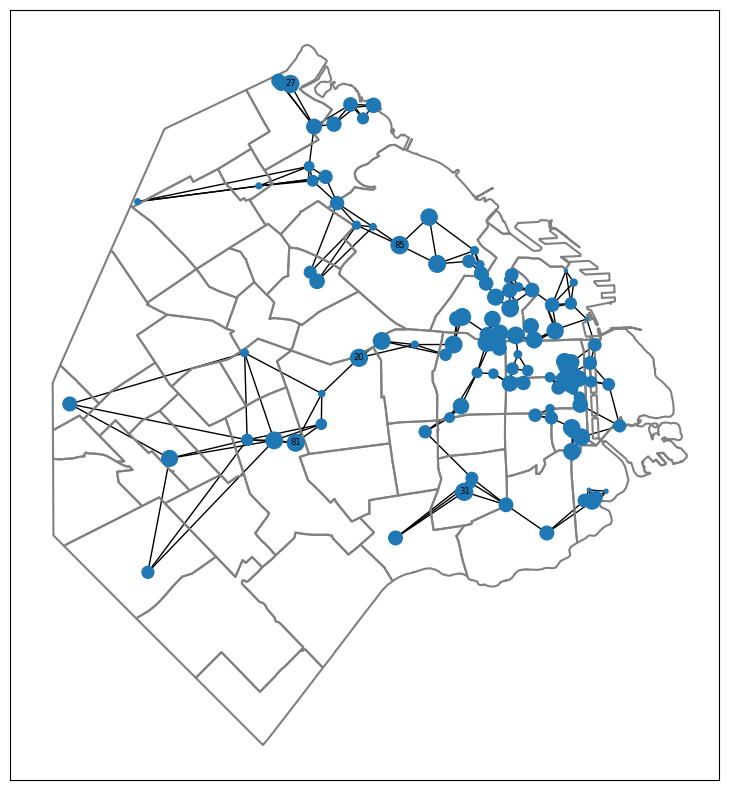

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres